In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [37]:
# fix random seed for reproducibility
np.random.seed(7)

# load the data
df = pd.read_csv("../Dataset/Manaus-Dados.csv")
df.set_index('date', inplace=True)
df

,notification.hr
date,
2016-01-01,761
2016-02-01,593
2016-03-01,572
2016-04-01,551
2016-05-01,546
2016-06-01,503
2016-07-01,370
2016-08-01,486
2016-09-01,822


In [38]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [39]:
# split into train and test sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]
print(len(train), len(test))

38 10


In [40]:
# convert an array of values into a dataset matrix
def create_ds(ds, look_back=1):
    dataX, dataY = [], []
    for i in range(len(ds)-look_back-1):
        a = ds[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(ds[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

In [41]:
# reshape into X = t and Y = t + 1
look_back = 1
trainX, trainY = create_ds(train, look_back)
testX, testY = create_ds(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [42]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
36/36 - 2s - loss: 0.1523 - 2s/epoch - 48ms/step
Epoch 2/50
36/36 - 0s - loss: 0.1225 - 106ms/epoch - 3ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0980 - 102ms/epoch - 3ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0788 - 137ms/epoch - 4ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0645 - 107ms/epoch - 3ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0548 - 111ms/epoch - 3ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0479 - 107ms/epoch - 3ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0434 - 113ms/epoch - 3ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0409 - 120ms/epoch - 3ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0394 - 110ms/epoch - 3ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0383 - 117ms/epoch - 3ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0372 - 110ms/epoch - 3ms/step
Epoch 13/50
36/36 - 0s - loss: 0.0368 - 113ms/epoch - 3ms/step
Epoch 14/50
36/36 - 0s - loss: 0.0360 - 117ms/epoch - 3ms/step
Epoch 15/50
36/36 - 0s - loss: 0.0361 - 110ms/epoch - 3ms/step
Epoch 16/50
36/36 - 0s - loss: 0.0346 - 113ms/epoch - 3ms/step
Epo

In [43]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test score: %.3f RMSE' % (testScore))

Train score: 260.479 RMSE
Test score: 272.398 RMSE


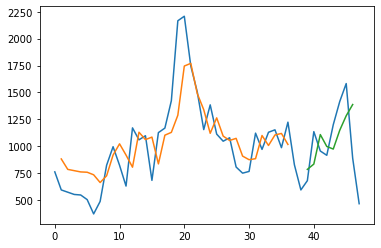

In [44]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()